<a href="https://colab.research.google.com/github/DanieleAngioni97/ML_Project/blob/master/Adversarial_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install the SecML library**

In [ ]:
!pip3 install secml

# **Load the CIFAR10 dataset**

In [ ]:
import torch 
import torchvision
import numpy as np
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR10

loader = CDataLoaderCIFAR10()
tr , ts = loader.load()

# Normalize the data
ts.X /= 255

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# **Load the pretrained ConvNet**

In [ ]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict


class CIFAR(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(CIFAR, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        # print(self.features)
        # print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = out_channels
    return nn.Sequential(*layers)


def cifar10(n_channel=128, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel,
           'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = CIFAR(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(
            'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar10-d875770b.pth')
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

model = cifar10(pretrained=True)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from secml.ml.features.normalization import CNormalizerMeanStd

transform = CNormalizerMeanStd(mean=(0.5,0.5,0.5), 
                              std=(0.5,0.5,0.5), 
                              with_std=True)


from secml.ml.classifiers import CClassifierPyTorch
clf = CClassifierPyTorch(model=model,
                         loss=criterion,
                         optimizer=optimizer,
                         preprocess = transform,
                         pretrained=True,
                         epochs=100,
                         batch_size=64,
                         input_shape=(3, 32, 32),
                         random_state=0)

label_torch = clf.predict(ts.X, return_decision_function=False)

from secml.ml.peval.metrics import CMetric
metric = CMetric.create('accuracy')
acc_torch = metric.performance_score(ts.Y, label_torch)

print("Model Accuracy: {}".format(acc_torch))

Model Accuracy: 0.9378


## Clone the repository to load the pretrained autoencoder

In [ ]:
!git clone https://github.com/DanieleAngioni97/ML_Project.git
!git pull

# **Create the architecture of the model and load the weights**

In [ ]:
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import numpy as np
from keras.models import load_model


def create_autoencoder():
 
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------
    #                       DEFINE AUTOENCODER ARCHITECTURE
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------

    input_img = Input(shape=(32, 32, 3))
 
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x) #16x16
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #4x4
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 
    # at this point the representation is (4, 4, 128)
 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x) #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #16x16
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #32x32
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
    autoencoder = Model(input_img, decoded)
    
    return autoencoder

path_autoencoders = "/content/ML_Project/"
model_name = "autoencoderCifar_100.h5"
autoencoder = create_autoencoder()
autoencoder.load_weights(path_autoencoders + model_name)

# **Evasion Attack**

In [ ]:
n_images = 1000
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:n_images, :]
#da aummentare

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 1.0  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5, #learning rate
    'eta_min': 2.0, #starting lr
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    double_init_ds=tr,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(attack_ds.X, attack_ds.Y)
print("Attack complete!")

Attack started...
Attack complete!


In [ ]:
eva_img = eva_adv_ds.X
eva_img_trasformed = np.transpose(eva_img.tondarray().reshape((n_images, 3, 32, 32)), (0,2,3,1))

decoded_imgs = autoencoder.predict(eva_img_trasformed)

from secml.array import CArray

decoded_imgs_trasformed = np.transpose(decoded_imgs, (0,3,1,2))
decoded_imgs_trasformed = CArray(decoded_imgs_trasformed.reshape(eva_img.shape))
y_pred_clean = clf.predict(decoded_imgs_trasformed)

acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=clf.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)
acc_attack_clean = metric.performance_score(
    y_true=attack_ds.Y, y_pred=y_pred_clean)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))
print("Accuracy on reduced test set after attack and cleaning the images: {:.2%}".format(acc_attack_clean))

Accuracy on reduced test set before attack: 94.50%
Accuracy on reduced test set after attack: 0.10%
Accuracy on reduced test set after attack and cleaning the images: 61.70%


# **Visualize the attacked and the reconstructed images**

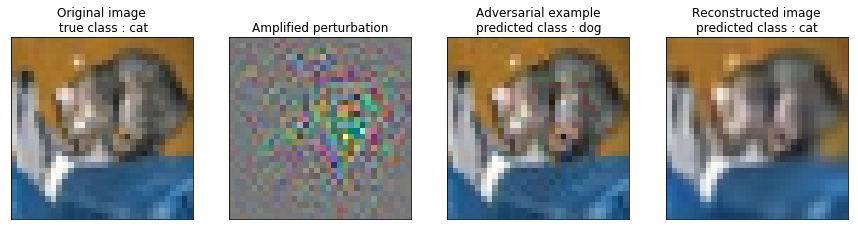

In [ ]:
from secml.figure import CFigure
%matplotlib inline

#Set k to change images
k=0

if k >= n_images:
    k = n_images - 1

start_img_k = attack_ds.X[k,:]
eva_img_k = eva_img[k,:]

# normalize perturbation for visualization
diff_img_k = start_img_k - eva_img_k
diff_img_k -= diff_img_k.min()
diff_img_k /= diff_img_k.max()

decode_img_k = decoded_imgs[k,:]

import numpy as np
start_img_k = np.transpose(start_img_k.tondarray().reshape((3, 32, 32)), (1, 2, 0))
diff_img_k = np.transpose(diff_img_k.tondarray().reshape((3, 32, 32)), (1, 2, 0))
eva_img_k = np.transpose(eva_img_k.tondarray().reshape((3, 32, 32)), (1, 2, 0))

fig = CFigure(width=15, height=5)
fig.subplot(1, 4, 1)
fig.sp.imshow(start_img_k)
fig.sp.title("Original image\n true class : " + classes[attack_ds.Y[k].item()])
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(1, 4, 2)
fig.sp.imshow(diff_img_k)
fig.sp.title("Amplified perturbation")
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(1, 4, 3)
fig.sp.imshow(eva_img_k)
fig.sp.title("Adversarial example\npredicted class : " + classes[eva_y_pred[k].item()])
fig.sp.xticks([])
fig.sp.yticks([])


fig.subplot(1, 4, 4)
fig.sp.imshow(decoded_imgs[k].reshape(32, 32, 3))
fig.sp.title("Reconstructed image\npredicted class : " + classes[y_pred_clean[k].item()])
fig.sp.xticks([])
fig.sp.yticks([])

fig.show()


# **Security Evaluation before autoencoding**

Running security evaluation...
Finish security evaluation...


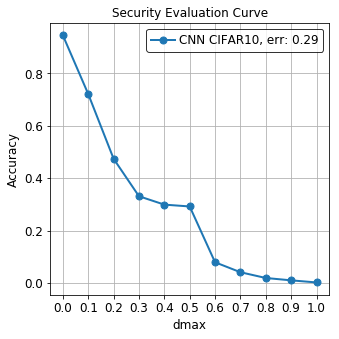

In [ ]:
# Perturbation levels to test
e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(attack_ds)
print("Finish security evaluation...")
 
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='CNN CIFAR10', show_average=True)
fig.show()

# **Security Evaluation after autoencoding**

Attack with dmax 0.0 started...
Attack complete!
Attack with dmax 0.1 started...
Attack complete!
Attack with dmax 0.2 started...
Attack complete!
Attack with dmax 0.3 started...
Attack complete!
Attack with dmax 0.4 started...
Attack complete!
Attack with dmax 0.5 started...
Attack complete!
Attack with dmax 0.6 started...
Attack complete!
Attack with dmax 0.7 started...
Attack complete!
Attack with dmax 0.8 started...
Attack complete!
Attack with dmax 0.9 started...
Attack complete!
Attack with dmax 1.0 started...
Attack complete!


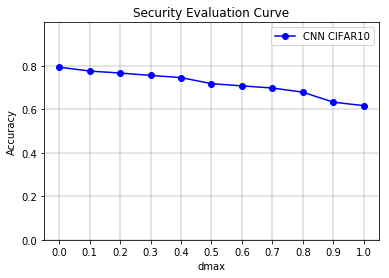

In [ ]:
dmax_max = 1.1
v_dmax = np.arange(0, dmax_max, 0.1)
idx_max = v_dmax.size
v_acc_attack_clean = np.zeros(idx_max)

for i in range(0,idx_max):
        dmax = v_dmax[i]
        pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                            double_init_ds=tr,
                                            distance=noise_type,
                                            dmax=dmax,
                                            solver_params=solver_params,
                                            y_target=y_target)

        print("Attack with dmax %.1f started..." %(dmax))
        eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(attack_ds.X, attack_ds.Y)
        print("Attack complete!")

        eva_img = eva_adv_ds.X
        eva_img_trasformed = np.transpose(eva_img.tondarray().reshape((n_images, 3, 32, 32)), (0,2,3,1))

        decoded_imgs = autoencoder.predict(eva_img_trasformed)

        decoded_imgs_trasformed = np.transpose(decoded_imgs, (0,3,1,2))
        decoded_imgs_trasformed = CArray(decoded_imgs_trasformed.reshape(eva_img.shape))
        y_pred_clean = clf.predict(decoded_imgs_trasformed)

        acc_attack_clean = metric.performance_score(
            y_true=attack_ds.Y, y_pred=y_pred_clean)
        
        v_acc_attack_clean[i] = acc_attack_clean


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(v_dmax,v_acc_attack_clean, 'b', marker='o')
plt.ylim(0, 1.0)
plt.grid(b=True, which='major', axis='both', color='k', linestyle='-', linewidth=0.2)
plt.xlabel('dmax')
plt.ylabel('Accuracy')
plt.title('Security Evaluation Curve')
plt.legend(['CNN CIFAR10'], loc='upper right')

major_ticks_x = np.arange(0, 1.1, 0.1)
major_ticks_y = np.arange(0, 1.0, 0.2)
ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)

ax.grid(which='both')
ax.grid(which='major')

plt.show()